# Common Import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cd /content/drive/My Drive/graduate_project

/content/drive/My Drive/graduate_project


In [0]:
import os
import pandas
import numpy
import random
import copy
import time

import keras.utils.np_utils as np_utils
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten, Dropout
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model

from IPython.display import SVG

import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

import itertools

import pandas as pd
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', -1)  # or 199

Using TensorFlow backend.


# Data Preprocessing function

In [0]:
CSV_PATH = r"""/content/drive/My Drive/graduate_project/Jfile"""
folder_list = os.listdir(CSV_PATH)
csv_list = list()



for file_name in folder_list:
    if file_name.split(".")[-1] == 'csv':
        f = open(CSV_PATH + "/" + file_name)
        temp_list = [f.read(), file_name.split(".")[0]]
        csv_list.append(temp_list)



def making_df_faster(csv_file_list, column_index=None, split_idx=1):
    
    if column_index == None:
        # column_index = numpy.arange(len(csv_file_list[0][0].split("\n")[0].split(",")))
        column_index = csv_file_list[0][0].split("\n")[0].split(",")
        column_index_2 = [item.replace('"', "") for item in column_index]
    column_index = numpy.hstack((column_index_2, "class_front", "class_back", 'class_combined'))
    
    result_df = pandas.DataFrame(columns=column_index)
    
    row_count = 0
    
    for csv_idx, csv_file in enumerate(csv_file_list):
        one_file_df = pandas.DataFrame(columns=column_index)
        for idx, line in enumerate(csv_file[0].split("\n")):
            if line != "" and idx != 0:
                one_file_df.loc[idx, one_file_df.columns[0]] = line.split(",")[0].replace('"', "")
                temp_data = numpy.array(line.split(",")[1:]).astype(numpy.float)
                temp_data[temp_data < 0] = 0
                one_file_df.loc[idx, one_file_df.columns[1:-3]] = temp_data
                one_file_df.loc[idx, 'class_front'] = int(csv_file[1].split("f")[0][split_idx:])
                one_file_df.loc[idx, 'class_back'] = int(csv_file[1].split("f")[1])
                one_file_df.loc[idx, 'class_combined'] = csv_file[1].split("f")[0][split_idx:] + "_" + csv_file[1].split("f")[1]
                                                           
                row_count += 1
            if row_count % 100 == 0:
                print(row_count)
        result_df = result_df.append(one_file_df)
        print(csv_idx, "th csv is combined complete \n\n\n\n")
    return result_df.reset_index(drop=True)


def deleting_non_detected_columns(given_df, final_data_type='float32'):
    str_df = given_df
#     str_df = None
#     if given_df.dtypes[1] != 'str':
#         str_df = given_df
#         str_df.loc[:, str_df.columns[1:]] = str_df.loc[:, str_df.columns[1:]].astype('str')
    
#     else:
#         str_df = given_df
    
    target_columns = str_df.describe().loc['unique', ][str_df.describe().loc['unique'] == 1].index
    
    for col in target_columns:
        str_df = str_df.drop(columns=col)
    
    final_df = str_df
    final_df.loc[:, final_df.columns[1:-3]] = final_df.loc[:, final_df.columns[1:-3]].astype(final_data_type)
    return final_df


def deleting_before_camera_set(given_df, desire_type='float32', target_column='class_combined', cutting_idx_rank=5):
    cal_df = given_df
#     cal_df = None
#     if given_df.dtypes[2] != desire_type:
#         cal_df = given_df
#         cal_df.loc[:, cal_df.columns[1:-3]] = cal_df.loc[:, cal_df.columns[1:-3]].astype(desire_type)
    
#     else:
#         cal_df = given_df
        
    final_df = pandas.DataFrame(columns=cal_df.columns)
    
    for cls in set(cal_df.loc[:, target_column]):
        max_value_idx_list = cal_df.loc[cal_df.loc[:, target_column] == cls].loc[:, cal_df.columns[3:-2:3]].astype('float32').idxmax()
        cutting_idx = max_value_idx_list.sort_values()[cutting_idx_rank]
        final_df = final_df.append(cal_df.loc[cal_df.loc[:, target_column] == cls][cutting_idx:])
    
    return final_df


def normalization_df(given_df, freq_threshold=0.2, z_axis_threshold=100):
    cal_df = given_df
    
    cls_list = given_df.columns
    df_analysis = given_df.describe(include=['freq', 'count'])
    
    threshold_col = df_analysis.loc['freq'][df_analysis.loc['freq'] > df_analysis.loc['count'] * freq_threshold]
    threshold_col = threshold_col.index
#     print(threshold_col.index)
    
    z_col = given_df.iloc[0, 1:-3] > z_axis_threshold
    z_col = z_col[z_col].index
    
    for col in threshold_col.to_list():
        cal_df.drop(columns=col)
    for col in z_col.to_list():
        cal_df.loc[:, col] = cal_df.loc[:, col] / cal_df.loc[:, col].max()
        
        
    return cal_df


def normalization_df_ver2(given_df):
    cal_df = given_df 
        
    z_df = cal_df.iloc[:, 3:-3:3]
    z_max = z_df.max()
    
    cal_df.iloc[:, 3:-3:3] = cal_df.iloc[:, 3:-3:3] / z_max
    return cal_df


def chunking_data(given_df, chunking_length=60, class_column_name='class_combined'):
    
    np_list = list()
    
    for cls in set(given_df.loc[:, class_column_name]):
        get_df = given_df[given_df.loc[:, class_column_name] == cls]
        np_list.append(get_df.to_numpy())
        
    chunked_data = list()
    chunked_label = list()
    for data in np_list:
        for idx in range(len(data) - chunking_length):
            chunked_data.append(numpy.array(data[idx:idx + chunking_length, 1:-3]))
            chunked_label.append(int(data[0, -3]))
    
    return numpy.array(chunked_data), np_utils.to_categorical(chunked_label)


def preprocessing(given_df, chk_len=60):
    print("deleting data before camera set")
    cal_df = deleting_before_camera_set(given_df)
    print("deleting data before camera set success\n\n")
    print("deleting undetected data")
    cal_df = deleting_non_detected_columns(cal_df)
    print("deleting undetected data done\n\n")
    print("normalizing data")
    cal_df = normalization_df_ver2(cal_df)
    print("normalizing data done \n\n")
    return chunking_data(cal_df, chk_len), cal_df

def making_df_faster_2(csv_file_list, column_index=None, split_idx=1):
    
    if column_index == None:
        # column_index = numpy.arange(len(csv_file_list[0][0].split("\n")[0].split(",")))
        column_index_2 = [idx + 1 for idx in range(len(csv_file_list[0][0].split("\n")[0].split(",")))]
#         column_index_2 = [item.replace('"', "") for item in column_index]
    column_index = numpy.hstack((column_index_2, "class_front", "class_back", 'class_combined'))
    
    result_df = pandas.DataFrame(columns=column_index)
    
    row_count = 0
    
    for csv_idx, csv_file in enumerate(csv_file_list):
        one_file_df = pandas.DataFrame(columns=column_index)
        for idx, line in enumerate(csv_file[0].split("\n")):
            if line != "" and idx != 0:
                one_file_df.loc[idx, one_file_df.columns[0]] = line.split(",")[0].replace('"', "")
#                 print(one_file_df, "\n" * 10, one_file_df.loc[idx, one_file_df.columns[1:]])
                temp_data = numpy.array(line.split(",")[1:]).astype(numpy.float)
                one_file_df.loc[idx, one_file_df.columns[1:-3]] = temp_data
                one_file_df.loc[idx, 'class_front'] = int(csv_file[1].split("f")[0][split_idx:])
                one_file_df.loc[idx, 'class_back'] = int(csv_file[1].split("f")[1])
                one_file_df.loc[idx, 'class_combined'] = csv_file[1].split("f")[0][split_idx:] + "_" + csv_file[1].split("f")[1]
                                                           
                row_count += 1
            if row_count % 100 == 0:
                print(row_count)
        result_df = result_df.append(one_file_df)
        print(csv_idx, "th csv is combined complete \n\n\n\n")
    return result_df.reset_index(drop=True)


### Data Faster_ver.1

In [0]:
df_faster_version = making_df_faster(csv_list)

0
0 th csv is combined complete 




100
1 th csv is combined complete 




200
2 th csv is combined complete 




300
3 th csv is combined complete 




400
4 th csv is combined complete 




500
5 th csv is combined complete 




6 th csv is combined complete 




600
7 th csv is combined complete 




700
8 th csv is combined complete 




800
9 th csv is combined complete 




900
10 th csv is combined complete 




1000
11 th csv is combined complete 




1100
12 th csv is combined complete 




1200
13 th csv is combined complete 




1300
14 th csv is combined complete 




15 th csv is combined complete 




1400
1500
16 th csv is combined complete 




1600
17 th csv is combined complete 




18 th csv is combined complete 




1700
19 th csv is combined complete 




1800
20 th csv is combined complete 




1900
21 th csv is combined complete 




2000
22 th csv is combined complete 




2100
23 th csv is combined complete 




2200
24 th csv is combined complete 




25 th c

### Data Faster_ver.2

In [0]:
# 학부생 데이터
csv_list_2 = list()
CSV_PATH_2 = r"""/content/drive/My Drive/graduate_project/Gfile"""

for file_name in os.listdir(CSV_PATH_2):
    if file_name.split(".")[-1] == 'csv':
        f = open(CSV_PATH_2 + "/" + file_name)
        temp_list = [f.read(), file_name.split(".")[0]]
        csv_list_2.append(temp_list)

        

df_faster_gfile = making_df_faster_2(csv_list_2, split_idx=2)

0
100
0 th csv is combined complete 




200
1 th csv is combined complete 




300
2 th csv is combined complete 




400
3 th csv is combined complete 




500
4 th csv is combined complete 




600
5 th csv is combined complete 




700
6 th csv is combined complete 




800
900
7 th csv is combined complete 




1000
8 th csv is combined complete 




1100
9 th csv is combined complete 




1200
10 th csv is combined complete 




1300
11 th csv is combined complete 




1400
12 th csv is combined complete 




1500
13 th csv is combined complete 




1600
1700
14 th csv is combined complete 




1800
15 th csv is combined complete 




1900
16 th csv is combined complete 




2000
17 th csv is combined complete 




2100
18 th csv is combined complete 




2200
19 th csv is combined complete 




2300
20 th csv is combined complete 




2400
2500
21 th csv is combined complete 




2600
22 th csv is combined complete 




2700
23 th csv is combined complete 




2800
24 th csv is 

## [1] New Data / 1D-CNN / Multi
- Data Preprocessing (6 Bodyparts extraction)

In [0]:
target_joint = ['shoulder', 'elbow', 'wrist']
joint_name = df_faster_version.columns.to_numpy()

temp_array = list()
for joint in joint_name:
    joint_flag = False
    for target in target_joint:
        if target in joint:
            temp_array.append(True)
            joint_flag = True
    if not joint_flag:
        temp_array.append(False)
        
joint_name[temp_array]

array(['left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z',
       'left_elbow_x', 'left_elbow_y', 'left_elbow_z', 'left_wrist_x',
       'left_wrist_y', 'left_wrist_z', 'right_shoulder_x',
       'right_shoulder_y', 'right_shoulder_z', 'right_elbow_x',
       'right_elbow_y', 'right_elbow_z', 'right_wrist_x', 'right_wrist_y',
       'right_wrist_z', 'v_left_shoulder_x', 'v_left_shoulder_y',
       'v_left_shoulder_z', 'v_left_elbow_x', 'v_left_elbow_y',
       'v_left_elbow_z', 'v_left_wrist_x', 'v_left_wrist_y',
       'v_left_wrist_z', 'v_right_shoulder_x', 'v_right_shoulder_y',
       'v_right_shoulder_z', 'v_right_elbow_x', 'v_right_elbow_y',
       'v_right_elbow_z', 'v_right_wrist_x', 'v_right_wrist_y',
       'v_right_wrist_z', 'a_left_shoulder_x', 'a_left_shoulder_y',
       'a_left_shoulder_z', 'a_left_elbow_x', 'a_left_elbow_y',
       'a_left_elbow_z', 'a_left_wrist_x', 'a_left_wrist_y',
       'a_left_wrist_z', 'a_right_shoulder_x', 'a_right_shoulder_y',
       'a_righ

In [0]:
joint_base = list(joint_name[temp_array])
joint_base.extend(joint_name[-3:])

target_df = df_faster_version.loc[:, joint_base]
target_df.iloc[:, 2:-3:3] = target_df.iloc[:, 2:-3:3] / numpy.max(target_df.iloc[:, 2:-3:3].to_numpy())

time_target_df = target_df
np_time = df_faster_version.loc[:, 'time'].to_numpy()
np_time_split = [item.split(":") for item in np_time]
np_time_sum = [3600*int(time[0]) + 60*int(time[1]) + float(time[2]) for time in np_time_split]

In [0]:
# Extracted Joint Coordinates(Left/Right Sho/Elb/Wrist) /Velocity/Acceleration
joint_base = list(joint_name[temp_array])
joint_base.extend(joint_name[-3:])

target_df = df_faster_version.loc[:, joint_base]

In [0]:
target_df.iloc[:, 2:-3:3] = target_df.iloc[:, 2:-3:3] / numpy.max(target_df.iloc[:, 2:-3:3].to_numpy())

In [0]:
# time data 
time_target_df = target_df
np_time = df_faster_version.loc[:, 'time'].to_numpy()
np_time_split = [item.split(":") for item in np_time]
np_time_sum = [3600*int(time[0]) + 60*int(time[1]) + float(time[2]) for time in np_time_split]
time_target_df['time'] = np_time_sum

In [0]:
# Add time data into table
time_target_df.head()

,left_shoulder_x,left_shoulder_y,left_shoulder_z,left_elbow_x,left_elbow_y,left_elbow_z,left_wrist_x,left_wrist_y,left_wrist_z,right_shoulder_x,right_shoulder_y,right_shoulder_z,right_elbow_x,right_elbow_y,right_elbow_z,right_wrist_x,right_wrist_y,right_wrist_z,v_left_shoulder_x,v_left_shoulder_y,v_left_shoulder_z,v_left_elbow_x,v_left_elbow_y,v_left_elbow_z,v_left_wrist_x,v_left_wrist_y,v_left_wrist_z,v_right_shoulder_x,v_right_shoulder_y,v_right_shoulder_z,v_right_elbow_x,v_right_elbow_y,v_right_elbow_z,v_right_wrist_x,v_right_wrist_y,v_right_wrist_z,a_left_shoulder_x,a_left_shoulder_y,a_left_shoulder_z,a_left_elbow_x,a_left_elbow_y,a_left_elbow_z,a_left_wrist_x,a_left_wrist_y,a_left_wrist_z,a_right_shoulder_x,a_right_shoulder_y,a_right_shoulder_z,a_right_elbow_x,a_right_elbow_y,a_right_elbow_z,a_right_wrist_x,a_right_wrist_y,a_right_wrist_z,class_front,class_back,class_combined,time
0,0.567229,0.447312,0.877501,0.580508,0.530268,0.881663,0,0,0,0.512439,0.455667,0.936357,0,0,0,0,0,0,0,0.0411296,6.64308e-08,0,0.0725504,0,0,0,0,0,1.18189,0,0,0,0,0,0,0,0,0.0428114,3.21698e-09,0,0.0194355,0,0,0,0,0,0.0202868,0,0,0,0,0,0,0,10,2,10_2,62119.686
1,0.568954,0.443284,0.874823,0.580922,0.527016,0.877614,0,0,0,0.528089,0.456153,0.943176,0,0,0,0,0,0,0,0,3.71007e-09,0,0,0,0,0,0,1.47273e-05,0.698701,0,0,0,0,0,0,0,0,0,0,7.10744e-07,0,0,0,0,0,5.26143e-06,0,0,0,0,0,0,0,0,10,2,10_2,62119.719
2,0.56173,0.440688,0.857762,0.580588,0.52271,0.867989,0,0,0,0.531783,0.457574,0.939266,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.17941e-05,0,0,0,0,0,0,0,0,1.34434e-06,0,0,0,0,0,0,0,0,7.96084e-07,0,0,0,0,0,0,0,0,10,2,10_2,62119.753
3,0.568548,0.434956,0.863159,0.577355,0.520596,0.868416,0,0,0,0.528513,0.445758,0.944457,0,0,0,0,0,0,0,0.553038,0,0,0.0437086,0,0,0,0,0,0.531923,0,0,0,0,0,0,0,0,0.068178,0,1.89656e-06,0.0303324,0,0,0,0,0,0.0279023,0,0,0,0,0,0,0,10,2,10_2,62119.786
4,0.571182,0.437023,0.868843,0.578024,0.523212,0.871759,0,0,0,0.530657,0.456083,0.939106,0,0,0,0,0,0,6.45937e-05,0.600586,6.1826e-09,8.175e-05,0.353317,0,0,0,0,0.000322656,0,0,0,0,0,0,0,0,7.44658e-06,0.00148588,1.0986e-09,4.55658e-06,0.00967527,0,0,0,0,2.12724e-05,0,0,0,0,0,0,0,0,10,2,10_2,62119.818


### Calculate Velocity and Acceleration

In [0]:
def calculate_velo_accele(given_df, columns_length=18):
    if 'time' not in list(given_df.columns):
        raise Exception("DataFrame should have 'time' column. Check Dataframe")
    
    class_comb = numpy.unique(given_df.loc[:, 'class_combined'].to_numpy())
    
    cal_np = given_df.to_numpy()
    velo_final_data = list()
    accele_final_data = list()
    position_final_data = list()
    etc_final_data = list()
    
    for idx, cls in enumerate(class_comb):
        temp_data = cal_np[cal_np[:, -2] == cls]
        temp_time = temp_data[1:, -1] - temp_data[:-1, -1]
        final_time = numpy.repeat(temp_time, columns_length).reshape((-1, temp_data.shape[0] - 1, columns_length))
        
        position_data = temp_data[2:, :columns_length]
        etc_data = temp_data[2:, columns_length*3:-1]
        
        velo_data = (temp_data[1:, :columns_length] - temp_data[:-1, :columns_length]) / final_time
        cp_velo = copy.deepcopy(velo_data)
        accele_data = (cp_velo[:, 1:] - cp_velo[:, :-1]) / final_time[0][1:]

        
        velo_final_data.extend(list(velo_data[0][1:]))
        accele_final_data.extend(list(accele_data[0]))
        position_final_data.extend(list(position_data))
        etc_final_data.extend(etc_data)
    temp_sum_data = numpy.hstack((
                                  numpy.array(velo_final_data) / numpy.max(velo_final_data),
                                  numpy.array(accele_final_data) / numpy.max(accele_final_data),
                                  etc_final_data))

    return pandas.DataFrame(temp_sum_data, columns=given_df.columns[columns_length:-1])

In [0]:
# Check Velocity and Acceleration data
calculated_df = calculate_velo_accele(target_df)
calculated_df.head()

,v_left_shoulder_x,v_left_shoulder_y,v_left_shoulder_z,v_left_elbow_x,v_left_elbow_y,v_left_elbow_z,v_left_wrist_x,v_left_wrist_y,v_left_wrist_z,v_right_shoulder_x,v_right_shoulder_y,v_right_shoulder_z,v_right_elbow_x,v_right_elbow_y,v_right_elbow_z,v_right_wrist_x,v_right_wrist_y,v_right_wrist_z,a_left_shoulder_x,a_left_shoulder_y,a_left_shoulder_z,a_left_elbow_x,a_left_elbow_y,a_left_elbow_z,a_left_wrist_x,a_left_wrist_y,a_left_wrist_z,a_right_shoulder_x,a_right_shoulder_y,a_right_shoulder_z,a_right_elbow_x,a_right_elbow_y,a_right_elbow_z,a_right_wrist_x,a_right_wrist_y,a_right_wrist_z,class_front,class_back,class_combined
0,-0.00100718,0.00248253,-0.00475848,0.00350922,0.00548047,7.56111e-06,0.00188089,0.00470737,-0.00479822,0.000270019,0.00529053,0.00100864,6.77615e-05,0.00732851,0.00271541,0.00062012,0.000554412,-0.00444397,-0.0010056,0.00147269,-0.00356059,0.000749617,0.00469157,0.00207841,0.00226363,0.00363592,-0.00155086,0.000844051,0.00335043,0.000805995,0.000125783,0.00593796,0.00418262,0.000122773,0.00105606,-0.000828543,10,1,10_1
1,-0.00659545,0.00965827,-0.0105457,-0.00496014,0.0108667,-0.00685395,0.00217853,0.0113997,-0.00186872,0.00196395,0.010669,-0.00105716,-0.00045739,0.0102365,-0.00468402,0.0102252,0.00386918,-0.00992015,-0.00529188,0.00679516,-0.0054803,-0.00802018,0.00510055,-0.0064976,0.000281851,0.00633743,0.00277413,0.00160409,0.00509326,-0.00195623,-0.000497299,0.00275376,-0.00700699,0.00909566,0.00313896,-0.00518575,10,1,10_1
2,-0.00209955,0.00346748,-0.0031532,0.00286822,0.00297727,-0.00103198,-0.0301464,-0.156137,0.000412181,0.00399157,0.011457,0.00162266,-0.00210908,0.0103103,0.000981758,0.00656969,0.0010376,-0.00271098,0.00399136,-0.00549604,0.00656292,0.00694984,-0.00700405,0.00516861,-0.0286974,-0.148736,0.00202493,0.00180008,0.000699515,0.00237908,-0.00146633,6.55462e-05,0.00502996,-0.00324529,-0.00251382,0.00640015,10,1,10_1
3,0.000463959,0.00287641,0.00147435,5.73898e-05,0.00256249,-0.00251028,-0.00697183,0.00689992,-0.00159146,-0.00253207,-0.00361418,0.000898696,0.000959724,-0.00337494,0.000557729,-0.0170372,-0.0147575,-0.00447381,0.00148625,-0.00034269,0.00268293,-0.00162964,-0.000240478,-0.000857077,0.013436,0.0945246,-0.00116166,-0.00378223,-0.00873786,-0.000419734,0.00177921,-0.00793435,-0.000245841,-0.0136866,-0.00915757,-0.00102204,10,1,10_1
4,0.00453684,-0.0126534,-0.00131773,0.00113183,-0.0115512,0.00376383,-0.0100668,0.0114866,-0.0149942,0.00222342,0.00522187,-0.00702305,-0.00260458,0.00638017,-7.97299e-05,-0.00878358,-0.0224481,-0.00133944,0.00361582,-0.013787,-0.00247874,0.000953863,-0.0125298,0.00557001,-0.00274766,0.00407198,-0.0118987,0.00422182,0.00784445,-0.00703276,-0.00316431,0.00866037,-0.000565922,0.00732736,-0.00682757,0.00278263,10,1,10_1


### 학부생 데이터 검증

In [0]:
# Export from raw data Gfile(학부데이터)
np_df_ver2 = df_faster_gfile.to_numpy()
temp_np = np_df_ver2[np_df_ver2[:, -3] == 10]
temp_np = temp_np[temp_np[:, 0] != '0']
temp_df = pandas.DataFrame(temp_np)
df_faster_gfile.loc[np_df_ver2[:, 0] == temp_np[0][0], :].to_numpy()[0][1:-3]
df_faster_version.loc[df_faster_version.to_numpy()[:, 0] == temp_np[0][0]].to_numpy()[0][62:-3]
target_time_np = df_faster_version.loc[df_faster_version.to_numpy()[:, 0] == temp_np[0][0]].to_numpy()[0]

In [0]:
calculated_df

Output hidden; open in https://colab.research.google.com to view.

### 데이터 만들기

In [0]:
# Position Data(JC), Velocity, Acceleration 데이터 나누기
position_data = target_df.iloc[:, :18]
velocity_data = target_df.iloc[:, 18:36]
acceleration_data = target_df.iloc[:, 36:]

In [0]:
velocity_data[joint_name[-3:]] = df_faster_version.iloc[:, -3:]
position_data[joint_name[-3:]] = df_faster_version.iloc[:, -3:]

In [0]:
# Chunking data
position_total_data = chunking_data(position_data, 30)
all_feature_total_data = chunking_data(calculated_df, 30)

In [0]:
all_feature_total_data[0].shape

(6192, 30, 35)

In [0]:
model_all_feature_shape = all_feature_total_data[0].shape[1:]
random_index = [i for i in range(all_feature_total_data[0].shape[0])]
random.shuffle(random_index)
np_ran_idx = numpy.array(random_index)

training_ratio = 0.5
test_ratio = 0.2

training_index = list(np_ran_idx[:int(np_ran_idx.shape[0] * training_ratio)])
validation_index = list(np_ran_idx[int(np_ran_idx.shape[0] * training_ratio):-int(np_ran_idx.shape[0] * test_ratio)])

In [0]:
# model_position_shape = (1, *position_total_data[0].shape[1:])
model_position_shape = position_total_data[0].shape[1:]

# 1D-CNN Model Structure

### position(JC)

In [0]:
model_position = Sequential()
model_position.add(Conv1D(128, 26, padding='same', input_shape=model_position_shape))
model_position.add(LeakyReLU(0.3))
model_position.add(Conv1D(256, 26, padding='same'))
model_position.add(LeakyReLU(0.3))
model_position.add(Dropout(0.0075))
model_position.add(Flatten())
model_position.add(Dense(128))
model_position.add(LeakyReLU(0.4))
model_position.add(Dense(position_total_data[1].shape[-1], activation='softmax'))

model_position.compile(loss='categorical_crossentropy', optimizer=Adam(0.0000045), metrics=['accuracy'])

In [0]:
position_history = model_position.fit(position_total_data[0][training_index], position_total_data[1][training_index],
                                      epochs=4000,
                                      validation_data=(position_total_data[0][validation_index],
                                                       position_total_data[1][validation_index]))

# model save
model_json = model_position.to_json()
with open("model_position_4000_1.json", "w") as json_file : 
    json_file.write(model_json)
    
# model weight save
model_position.save_weights("model_position_4000_1.h5")
print("Saved model to disk")


Train on 3096 samples, validate on 1858 samples
Epoch 1/4000
3096/3096 [==============================] - 2s 523us/step - loss: 3.3562 - acc: 0.0856 - val_loss: 3.1968 - val_acc: 0.0888
Epoch 2/4000
3096/3096 [==============================] - 1s 284us/step - loss: 3.1112 - acc: 0.0904 - val_loss: 3.0983 - val_acc: 0.0915
Epoch 3/4000
3096/3096 [==============================] - 1s 292us/step - loss: 3.0471 - acc: 0.0956 - val_loss: 3.0643 - val_acc: 0.0915
Epoch 4/4000
3096/3096 [==============================] - 1s 304us/step - loss: 3.0233 - acc: 0.1021 - val_loss: 3.0453 - val_acc: 0.0915
Epoch 5/4000
3096/3096 [==============================] - 1s 279us/step - loss: 3.0076 - acc: 0.0969 - val_loss: 3.0356 - val_acc: 0.0996
Epoch 6/4000
3096/3096 [==============================] - 1s 300us/step - loss: 2.9958 - acc: 0.0979 - val_loss: 3.0266 - val_acc: 0.0996
Epoch 7/4000
3096/3096 [==============================] - 1s 293us/step - loss: 2.9844 - acc: 0.0959 - val_loss: 3.0144 - va

In [0]:
# history save
import json
with open('jc_history_4000.json', 'w') as f:
    json.dump(position_history.history, f)

In [0]:
# model load
from keras.models import model_from_json 
json_file = open("model_position_4000.json", "r")
loaded_model_json = json_file.read() 
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# model weight load 
model_position.load_weights("model_position_4000.h5")
print("Loaded model from disk")

# evaluate
model_position.compile(loss='categorical_crossentropy', optimizer=Adam(0.0000045), metrics=['accuracy'])
t_score = model_position.evaluate(position_total_data[0][training_index], position_total_data[1][training_index],verbose=0)
v_score = model_position.evaluate(position_total_data[0][validation_index], position_total_data[1][validation_index],verbose=0)
m_score = model_position.evaluate(position_total_data[0], position_total_data[1],verbose=0)

print('JC training loss : ' + str(t_score[0]))
print('JC validation loss : ' + str(v_score[0]))
print("")
print('JC training accuracy : ' + str(t_score[1]))
print('JC validation accuracy : ' + str(v_score[1]))
print("")
print('JC total loss : ' + str(m_score[0]))
print('JC total accuracy : ' + str(m_score[1]))

Loaded model from disk
JC training loss : 0.23831104621945734
JC validation loss : 0.297490755663493

JC training accuracy : 0.8898578809829337
JC validation accuracy : 0.8719052744886975

JC total loss : 0.3353617418608391
JC total accuracy : 0.8766760211478597


### all_position(JC+Speed)

In [0]:
model_all_feature = Sequential()
model_all_feature.add(Conv1D(128, 26, padding='same', input_shape=model_all_feature_shape))
model_all_feature.add(LeakyReLU(0.3))
model_all_feature.add(Conv1D(256, 26, padding='same'))
model_all_feature.add(LeakyReLU(0.3))
model_all_feature.add(Dropout(0.0075))
model_all_feature.add(Flatten())
model_all_feature.add(Dense(128))
model_all_feature.add(LeakyReLU(0.4))
model_all_feature.add(Dense(position_total_data[1].shape[-1], activation='softmax'))

model_all_feature.compile(loss='categorical_crossentropy', optimizer=Adam(0.0000045), metrics=['accuracy'])





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [0]:
all_feature_history = model_all_feature.fit(all_feature_total_data[0][training_index], all_feature_total_data[1][training_index],
                                            epochs=4000,
                                            validation_data=(all_feature_total_data[0][validation_index],
                                                             all_feature_total_data[1][validation_index]))

# model save
model_json = model_all_feature.to_json()
with open("model_all_feature_4000_1.json", "w") as json_file : 
    json_file.write(model_json)
    
# model weight save
model_all_feature.save_weights("model_all_feature_4000_1.h5")
print("Saved model to disk")


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 3096 samples, validate on 1858 samples
Epoch 1/4000





3096/3096 [==============================] - 17s 5ms/step - loss: 3.5527 - acc: 0.0688 - val_loss: 3.5506 - val_acc: 0.1001
Epoch 2/4000
3096/3096 [==============================] - 1s 301us/step - loss: 3.5469 - acc: 0.1027 - val_loss: 3.5453 - val_acc: 0.1055
Epoch 3/4000
3096/3096 [==============================] - 1s 311us/step - loss: 3.5396 - acc: 0.0943 - val_loss: 3.5379 - val_acc: 0.1071
Epoch 4/4000
3096/3096 [==============================] - 1s 311us/step - loss: 3.5290 - acc: 0.0927 - val_loss: 3.5259 - val_acc: 0.1071
Epoch 5/4000
3096/3096 [==============================] - 1s 324us/step - loss: 3.5116 - acc: 0.0924 - val_loss: 3.5048 - val_acc: 0.1076
Epoch 6/4000
3096/3096 [==============================] - 1s 305us/step - loss: 3.4805 - acc: 0.0917 - val_loss: 3.4653 - val_acc: 0.1055
Epoch 7/4000
3096/3096 

2nd try

In [0]:
from keras.callbacks import CSVLogger
csv_logger = CSVLogger('jc_4000_history.csv', append=True, separator=';')

position_history = model_position.fit(position_total_data[0][training_index], position_total_data[1][training_index],
                                      epochs=4000,
                                      validation_data=(position_total_data[0][validation_index],
                                                       position_total_data[1][validation_index]))

# model save
model_json = model_position.to_json()
with open("model_position_4000_1.json", "w") as json_file : 
    json_file.write(model_json)
    
# model weight save
model_position.save_weights("model_position_4000_1.h5")
print("Saved model to disk")


Train on 3096 samples, validate on 1858 samples
Epoch 1/4000
3096/3096 [==============================] - 1s 430us/step - loss: 3.3869 - acc: 0.0759 - val_loss: 3.2749 - val_acc: 0.0802
Epoch 2/4000
3096/3096 [==============================] - 1s 250us/step - loss: 3.2038 - acc: 0.0943 - val_loss: 3.1710 - val_acc: 0.0813
Epoch 3/4000
3096/3096 [==============================] - 1s 242us/step - loss: 3.1279 - acc: 0.0988 - val_loss: 3.1199 - val_acc: 0.0813
Epoch 4/4000
3096/3096 [==============================] - 1s 249us/step - loss: 3.0881 - acc: 0.0988 - val_loss: 3.0884 - val_acc: 0.0813
Epoch 5/4000
3096/3096 [==============================] - 1s 251us/step - loss: 3.0624 - acc: 0.1001 - val_loss: 3.0697 - val_acc: 0.1082
Epoch 6/4000
3096/3096 [==============================] - 1s 245us/step - loss: 3.0444 - acc: 0.1076 - val_loss: 3.0570 - val_acc: 0.0958
Epoch 7/4000
3096/3096 [==============================] - 1s 262us/step - loss: 3.0318 - acc: 0.1001 - val_loss: 3.0446 - va

In [0]:
from keras.callbacks import CSVLogger
csv_logger = CSVLogger('jcs_4000_history.csv', append=True, separator=';')

all_feature_history = model_all_feature.fit(all_feature_total_data[0][training_index], all_feature_total_data[1][training_index],
                                            epochs=4000,
                                            validation_data=(all_feature_total_data[0][validation_index],
                                                             all_feature_total_data[1][validation_index]), callbacks=[csv_logger])

# model save
model_json = model_all_feature.to_json()
with open("model_all_feature_4000_1.json", "w") as json_file : 
    json_file.write(model_json)
    
# model weight save
model_all_feature.save_weights("model_all_feature_4000_1.h5")
print("Saved model to disk")


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 3096 samples, validate on 1858 samples
Epoch 1/4000





3096/3096 [==============================] - 17s 6ms/step - loss: 3.5534 - acc: 0.0862 - val_loss: 3.5512 - val_acc: 0.1001
Epoch 2/4000
3096/3096 [==============================] - 1s 268us/step - loss: 3.5469 - acc: 0.1121 - val_loss: 3.5453 - val_acc: 0.1076
Epoch 3/4000
3096/3096 [==============================] - 1s 269us/step - loss: 3.5384 - acc: 0.1124 - val_loss: 3.5366 - val_acc: 0.1006
Epoch 4/4000
3096/3096 [==============================] - 1s 260us/step - loss: 3.5255 - acc: 0.1063 - val_loss: 3.5215 - val_acc: 0.1017
Epoch 5/4000
3096/3096 [==============================] - 1s 266us/step - loss: 3.5034 - acc: 0.1053 - val_loss: 3.4934 - val_acc: 0.1012
Epoch 6/4000
3096/3096 [==============================] - 1s 270us/step - loss: 3.4632 - acc: 0.1059 - val_loss: 3.4414 - val_acc: 0.1012
Epoch 7/4000
3096/3096 

In [0]:
# model load
from keras.models import model_from_json 
json_file = open("model_all_feature_4000.json", "r")
loaded_model_json = json_file.read() 
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# model weight load 
model_all_feature.load_weights("model_all_feature_4000.h5")
print("Loaded model from disk")

# evaluate
model_all_feature.compile(loss='categorical_crossentropy', optimizer=Adam(0.0000045), metrics=['accuracy'])
t_score = model_all_feature.evaluate(all_feature_total_data[0][training_index], all_feature_total_data[1][training_index],verbose=0)
v_score = model_all_feature.evaluate(all_feature_total_data[0][validation_index], all_feature_total_data[1][validation_index],verbose=0)
m_score = model_all_feature.evaluate(all_feature_total_data[0], all_feature_total_data[1],verbose=0)

print('JCS total training loss : ' + str(t_score[0]))
print('JCS total training accuracy : ' + str(t_score[1]))
print("")
print('JCS total validation loss : ' + str(v_score[0]))
print('JCS total validation accuracy : ' + str(v_score[1]))
print("")
print('JCS total loss : ' + str(m_score[0]))
print('JCS total accuracy : ' + str(m_score[1]))

Loaded model from disk
JCS total training loss : 0.22219979409633797
JCS total training accuracy : 0.9744832039803497

JCS total validation loss : 0.2754985476323715
JCS total validation accuracy : 0.9682454251883746

JCS total loss : 0.2530675678346729
JCS total accuracy : 0.9714147286821705


In [0]:
position_total_data[1][training_index].shape

(3096, 35)

In [0]:
(model_position.predict(position_total_data[0][training_index])).shape

(3096, 35)

Compute F1 Score/ Precision/ Recall

In [0]:
from sklearn.metrics import classification_report

# JC_training
print(classification_report(numpy.argmax(position_total_data[1][training_index], axis=1), numpy.argmax(model_position.predict(position_total_data[0][training_index]), axis=1)))

              precision    recall  f1-score   support

          10       1.00      0.99      0.99        98
          11       1.00      1.00      1.00        72
          12       1.00      1.00      1.00        69
          13       1.00      1.00      1.00       121
          14       1.00      1.00      1.00        88
          15       1.00      1.00      1.00       102
          16       1.00      1.00      1.00        34
          17       1.00      1.00      1.00       117
          18       1.00      1.00      1.00        22
          19       1.00      1.00      1.00        71
          20       1.00      1.00      1.00        90
          21       1.00      1.00      1.00        84
          22       1.00      1.00      1.00        50
          23       1.00      1.00      1.00        83
          24       1.00      1.00      1.00        73
          25       1.00      1.00      1.00       105
          26       1.00      1.00      1.00        45
          27       1.00    

In [0]:
# JC_validation
print(classification_report(numpy.argmax(position_total_data[1][validation_index], axis=1), numpy.argmax(model_position.predict(position_total_data[0][validation_index]), axis=1)))

              precision    recall  f1-score   support

          10       0.98      0.96      0.97        51
          11       1.00      0.98      0.99        52
          12       0.94      0.96      0.95        46
          13       1.00      1.00      1.00        70
          14       0.96      1.00      0.98        55
          15       1.00      1.00      1.00        64
          16       1.00      1.00      1.00        19
          17       1.00      0.99      0.99        67
          18       1.00      0.93      0.97        15
          19       0.98      1.00      0.99        47
          20       1.00      0.98      0.99        49
          21       1.00      1.00      1.00        63
          22       1.00      0.95      0.98        42
          23       1.00      1.00      1.00        53
          24       1.00      1.00      1.00        38
          25       1.00      1.00      1.00        64
          26       0.97      0.93      0.95        42
          27       0.91    

In [0]:
from sklearn.metrics import classification_report

# JCS_training
print(classification_report(numpy.argmax(all_feature_total_data[1][training_index], axis=1), numpy.argmax(model_all_feature.predict(all_feature_total_data[0][training_index]), axis=1)))

              precision    recall  f1-score   support

          10       0.92      0.99      0.96        86
          11       0.93      0.95      0.94        73
          12       0.99      0.99      0.99        74
          13       0.97      0.96      0.97       109
          14       0.90      0.99      0.94        85
          15       0.99      0.94      0.97        90
          16       0.97      0.99      0.98        67
          17       0.92      0.96      0.94       112
          18       0.96      1.00      0.98        64
          19       0.96      0.96      0.96        71
          20       0.99      0.95      0.97        87
          21       0.91      0.87      0.89        83
          22       0.98      0.84      0.90        62
          23       0.96      0.95      0.96        84
          24       0.97      1.00      0.98        59
          25       1.00      0.98      0.99       102
          26       1.00      1.00      1.00        42
          27       0.92    

In [0]:
# JCS_validation
print(classification_report(numpy.argmax(all_feature_total_data[1][validation_index], axis=1), numpy.argmax(model_all_feature.predict(all_feature_total_data[0][validation_index]), axis=1)))

              precision    recall  f1-score   support

          10       0.96      1.00      0.98        49
          11       0.89      0.95      0.92        43
          12       0.95      0.97      0.96        39
          13       0.96      0.91      0.93        78
          14       0.98      1.00      0.99        47
          15       0.93      0.98      0.95        54
          16       0.90      0.97      0.93        29
          17       0.98      0.90      0.94        60
          18       0.96      0.96      0.96        49
          19       0.97      0.95      0.96        38
          20       0.96      0.88      0.92        58
          21       0.89      0.93      0.91        60
          22       0.78      0.76      0.77        37
          23       0.90      0.90      0.90        51
          24       0.98      1.00      0.99        43
          25       1.00      0.99      0.99        68
          26       0.98      0.98      0.98        43
          27       0.87    

In [0]:
from sklearn.metrics import classification_report

# JCS_training
print(classification_report(numpy.argmax(all_feature_total_data[1][training_index], axis=1), numpy.argmax(model_all_feature.predict(all_feature_total_data[0][training_index]), axis=1)))

              precision    recall  f1-score   support

          10       1.00      1.00      1.00        75
          11       1.00      1.00      1.00        88
          12       1.00      1.00      1.00        69
          13       1.00      1.00      1.00       114
          14       1.00      1.00      1.00        91
          15       1.00      1.00      1.00        90
          16       1.00      1.00      1.00        58
          17       1.00      1.00      1.00       107
          18       1.00      1.00      1.00        70
          19       1.00      1.00      1.00        67
          20       1.00      1.00      1.00        89
          21       1.00      1.00      1.00        87
          22       1.00      1.00      1.00        65
          23       1.00      1.00      1.00        92
          24       1.00      1.00      1.00        63
          25       1.00      1.00      1.00        94
          26       1.00      1.00      1.00        52
          27       1.00    

In [0]:
# JCS_validation
print(classification_report(numpy.argmax(all_feature_total_data[1][validation_index], axis=1), numpy.argmax(model_all_feature.predict(all_feature_total_data[0][validation_index]), axis=1)))

              precision    recall  f1-score   support

          10       0.96      0.91      0.93        53
          11       1.00      0.98      0.99        44
          12       0.85      0.81      0.83        42
          13       0.87      0.97      0.92        64
          14       0.90      0.98      0.94        46
          15       0.89      0.92      0.90        62
          16       0.96      0.87      0.92        31
          17       0.83      0.89      0.86        65
          18       0.95      0.91      0.93        46
          19       0.89      0.98      0.93        42
          20       0.84      0.86      0.85        57
          21       0.98      0.73      0.84        56
          22       0.75      0.82      0.78        33
          23       0.89      0.91      0.90        44
          24       0.98      1.00      0.99        42
          25       1.00      1.00      1.00        56
          26       1.00      0.96      0.98        24
          27       0.76    

In [0]:
# # model load
# from keras.models import model_from_json 
# json_file = open("model_all_feature_4000.json", "r")
# loaded_model_json = json_file.read() 
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)

# # model weight load 
# model_all_feature.load_weights("model_all_feature_4000.h5")
# print("Loaded model from disk")

# evaluate
model_all_feature.compile(loss='categorical_crossentropy', optimizer=Adam(0.0000045), metrics=['accuracy'])
t_score = model_all_feature.evaluate(all_feature_total_data[0][training_index], all_feature_total_data[1][training_index],verbose=0)
v_score = model_all_feature.evaluate(all_feature_total_data[0][validation_index], all_feature_total_data[1][validation_index],verbose=0)
m_score = model_all_feature.evaluate(all_feature_total_data[0], all_feature_total_data[1],verbose=0)

print('JCS total training loss : ' + str(t_score[0]))
print('JCS total training accuracy : ' + str(t_score[1]))
print("")
print('JCS total validation loss : ' + str(v_score[0]))
print('JCS total validation accuracy : ' + str(v_score[1]))
print("")
print('JCS total loss : ' + str(m_score[0]))
print('JCS total accuracy : ' + str(m_score[1]))

JCS total training loss : 0.0012907759623075005
JCS total training accuracy : 1.0

JCS total validation loss : 0.45901385681011087
JCS total validation accuracy : 0.9429494079655544

JCS total loss : 0.2249853792436579
JCS total accuracy : 0.9720607235142119


### Plotting JC, JCS-1DCNN

In [0]:
def plotting_history_loss(given_history, title='Loss graph'):
    fontP = FontProperties()
    plt.plot(given_history.history['loss'])
    plt.plot(given_history.history['val_loss'])
    plt.legend(['loss', 'val_loss'], prop=fontP, bbox_to_anchor=(1.04,1), loc="upper left")
    plt.title(title)
    plt.ylim(0,3.6)
    plt.show()
    
    
def plotting_history_acc(given_history, title='Accruacy graph'):
    fontP = FontProperties()
    plt.plot(given_history.history['acc'])
    plt.plot(given_history.history['val_acc'])
    plt.legend(['acc', 'val_acc'], prop=fontP, bbox_to_anchor=(1.04,1), loc="upper left")
    plt.title(title)
    plt.ylim(0,1.1)
    plt.show()

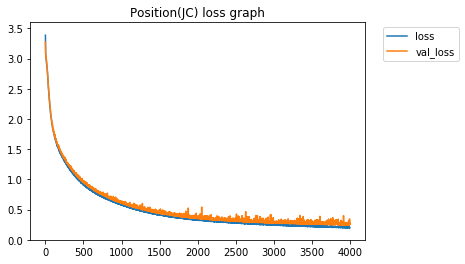

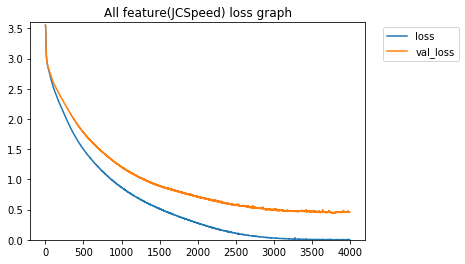

In [0]:
JC_loss = plotting_history_loss(position_history, 'Position(JC) loss graph')
JCS_loss = plotting_history_loss(all_feature_history, 'All feature(JCSpeed) loss graph')

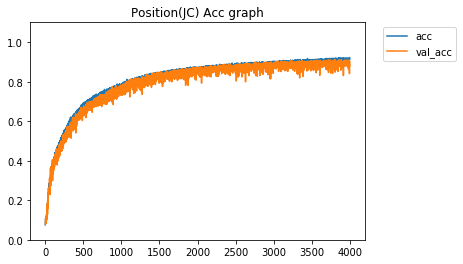

In [0]:
JC_1dcnn_acc = plotting_history_acc(position_history, 'Position(JC) Acc graph')


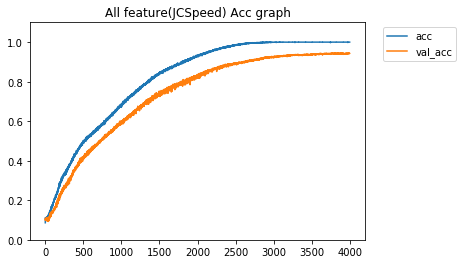

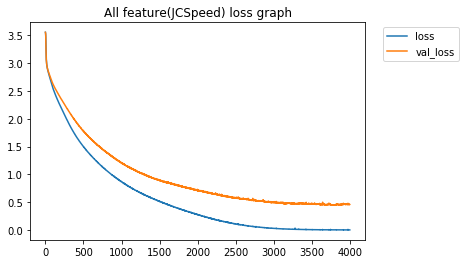

In [0]:
JCS_1dcnn_acc = plotting_history_acc(all_feature_history, 'All feature(JCSpeed) Acc graph')
JCS_1dcnn_loss = plotting_history_loss(all_feature_history, 'All feature(JCSpeed) loss graph')

### lstm JC

In [0]:
model_check = Sequential()
model_check.add(LSTM(128, activation=LeakyReLU(0.3), input_shape=position_total_data[0][0].shape))
model_check.add(Dense(256, activation=LeakyReLU(0.3)))
model_check.add(Dense(512, activation=LeakyReLU(0.3)))
model_check.add(Dense(2, activation='sigmoid'))

model_check.compile(loss='categorical_crossentropy', optimizer=Adam(0.0001), metrics=['accuracy'])

# model_check = Sequential()
# model_check.add(LSTM(128, activation=LeakyReLU(0.3), input_shape=position_total_data[0][0].shape))
# model_check.add(Dense(256, activation=LeakyReLU(0.3)))
# model_check.add(Dense(512, activation=LeakyReLU(0.3)))
# model_check.add(Dense(check_data[1].shape[1], activation='softmax'))

# model_check.compile(loss='categorical_crossentropy', optimizer=Adam(0.0001), metrics=['accuracy'])

NameError: name 'Sequential' is not defined

In [0]:
# jc data copy
check_data = copy.deepcopy(position_total_data)
check_label = numpy.argmax(check_data[1], axis=1)
check_label[check_label <= 28] = 0
check_label[check_label > 28] = 1
numpy.unique(check_label)
check_label = np_utils.to_categorical(check_label)

In [0]:
JC_lstm_binary_history = model_check.fit(check_data[0], check_label, epochs=1000)

Epoch 1/1000
6414/6414 [==============================] - 6s 967us/step - loss: 0.6755 - accuracy: 0.5748
Epoch 2/1000
6414/6414 [==============================] - 6s 885us/step - loss: 0.4692 - accuracy: 0.7786
Epoch 3/1000
6414/6414 [==============================] - 6s 895us/step - loss: 0.3455 - accuracy: 0.8625
Epoch 4/1000
6414/6414 [==============================] - 6s 872us/step - loss: 0.2769 - accuracy: 0.8949
Epoch 5/1000
6414/6414 [==============================] - 6s 913us/step - loss: 0.2630 - accuracy: 0.9027
Epoch 6/1000
6414/6414 [==============================] - 6s 894us/step - loss: 0.2125 - accuracy: 0.9256
Epoch 7/1000
6414/6414 [==============================] - 6s 892us/step - loss: 0.2144 - accuracy: 0.9238
Epoch 8/1000
6414/6414 [==============================] - 6s 915us/step - loss: 0.2158 - accuracy: 0.9224
Epoch 9/1000
6414/6414 [==============================] - 6s 868us/step - loss: 0.1901 - accuracy: 0.9395
Epoch 10/1000
6414/6414 [=====================

In [0]:
# model evaluation
jc_lstm_loss_and_metrics = model_check.evaluate(check_data[0], check_label)
print('')
print('jc_loss_and_acc : '+str(jc_lstm_loss_and_metrics))

# model save
from keras.models import load_model
model_check.save('jc_lstm_binary.h5')

# jc_lstm_binary = load_model('jc_lstm_binary.h5')

NameError: name 'model_check' is not defined

### lstm JCS

In [0]:
jcs_model_check = Sequential()
jcs_model_check.add(LSTM(128, activation=LeakyReLU(0.3), input_shape=all_feature_total_data[0][0].shape))
jcs_model_check.add(Dense(256, activation=LeakyReLU(0.3)))
jcs_model_check.add(Dense(512, activation=LeakyReLU(0.3)))
jcs_model_check.add(Dense(2, activation='sigmoid'))

model_check.compile(loss='categorical_crossentropy', optimizer=Adam(0.0001), metrics=['accuracy'])


In [0]:
# jcs data copy
check_jcs_data = copy.deepcopy(all_feature_total_data)
check_jcs_label = numpy.argmax(check_jcs_data[1], axis=1)
check_jcs_label[check_jcs_label <= 28] = 0
check_jcs_label[check_jcs_label > 28] = 1
numpy.unique(check_jcs_label)
check_jcs_label = np_utils.to_categorical(check_jcs_label)

In [0]:
JCS_lstm_binary_history = jcs_model_check.fit(check_jcs_data[0], check_jcs_label, epochs=300)

Epoch 1/300
6192/6192 [==============================] - 6s 969us/step - loss: 0.5836 - accuracy: 0.7027
Epoch 2/300
6192/6192 [==============================] - 6s 897us/step - loss: 0.3050 - accuracy: 0.8808
Epoch 3/300
6192/6192 [==============================] - 6s 895us/step - loss: 0.2578 - accuracy: 0.8960
Epoch 4/300
6192/6192 [==============================] - 6s 896us/step - loss: 0.2413 - accuracy: 0.9039
Epoch 5/300
6192/6192 [==============================] - 6s 916us/step - loss: 0.2043 - accuracy: 0.9184
Epoch 6/300
6192/6192 [==============================] - 6s 899us/step - loss: 0.1804 - accuracy: 0.9315
Epoch 7/300
6192/6192 [==============================] - 6s 927us/step - loss: 0.1662 - accuracy: 0.9352
Epoch 8/300
6192/6192 [==============================] - 6s 896us/step - loss: 0.1304 - accuracy: 0.9485
Epoch 9/300
6192/6192 [==============================] - 5s 885us/step - loss: 0.1251 - accuracy: 0.9503
Epoch 10/300
6192/6192 [==============================]

In [0]:
# model evaluation
jcs_lstm_loss_and_metrics = model_check.evaluate(check_jcs_data[0], check_jcs_label)
print('')
print('jcs_loss_and_acc : '+str(jcs_lstm_loss_and_metrics))

# model save
from keras.models import load_model
model_check.save('jcs_lstm_binary.h5')

# jc_lstm_binary = load_model('jc_lstm_binary.h5')

AttributeError: 'LeakyReLU' object has no attribute '__name__'

### Plotting lstm

In [0]:
def plotting_history_loss(given_history, title='Loss graph'):
    fontP = FontProperties()
    plt.plot(given_history.history['loss'])
    plt.legend(['loss'], prop=fontP, bbox_to_anchor=(1.04,1), loc="upper left")
    plt.title(title)
    plt.xlim(0,300)
    plt.ylim(0,1.0)
    plt.show()
    
    
def plotting_history_acc(given_history, title='Accruacy graph'):
    fontP = FontProperties()
    plt.plot(given_history.history['accuracy'])
    plt.legend(['acc'], prop=fontP, bbox_to_anchor=(1.04,1), loc="upper left")
    plt.title(title)
    plt.xlim(0,300)
    plt.ylim(0,1.1)
    plt.show()

In [0]:
JC_lstm_binary_history.history.keys()

dict_keys(['loss', 'accuracy'])

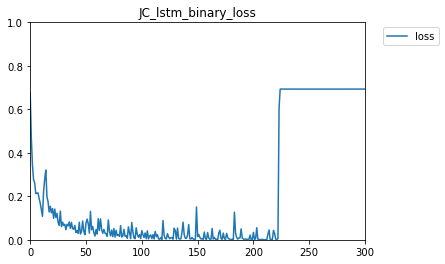

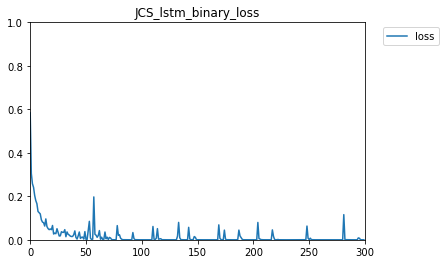

In [0]:
JC_lstm_loss = plotting_history_loss(JC_lstm_binary_history, 'JC_lstm_binary_loss')
JCS_lstm_loss = plotting_history_loss(JCS_lstm_binary_history, 'JCS_lstm_binary_loss')

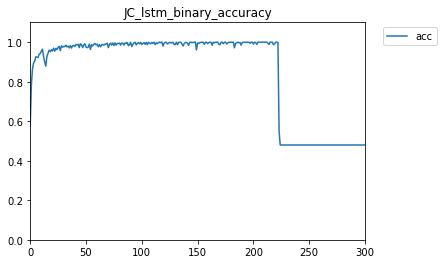

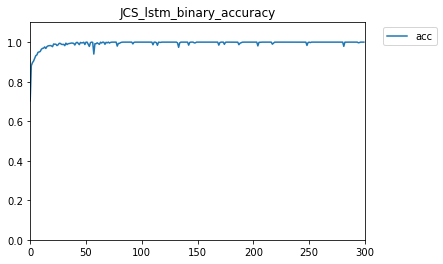

In [0]:
JC_lstm_acc = plotting_history_acc(JC_lstm_binary_history, 'JC_lstm_binary_accuracy')
JCS_lstm_acc = plotting_history_acc(JCS_lstm_binary_history, 'JCS_lstm_binary_accuracy')

### model import and evaluate

In [0]:
from keras.models import load_model
jc_lstm_model = model_check.load_weights('jc_lstm_model.h5')
jc_lstm_model = load_model('jc_lstm_model.h5')

NameError: name 'model_check' is not defined